In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import sys
from pathlib import Path

# Ensure src is in the Python path
try:
    ROOT = Path(__file__).resolve().parent.parent
except NameError:
    ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

from src.config import DATA_RAW, DATA_PROCESSED, OUTPUT_PLOTS
from src.data_loader import load_all_csv
from src.preprocessing import preprocess
from src.tags import tag_events, tag_frequencies
from src.anomaly_detection import detect_anomalies, tag_anomalies
from src.plotting import plot_time_with_events, plot_tag_anomalies, plot_time_with_unplugged_events, plot_time_with_state_bands, plot_time_with_tag_markers, plot_anomalies
pd.set_option("display.max_columns", None)

# Load Data/data_loader

In [2]:
df = load_all_csv()
df.head()

Combined data saved to ..\data\processed\merged_all_raw_data.csv


,date,time,ion_analog,voltage_ion,pressure_ion,conv_analog,voltage_conv,pressure_conv,tags
0,2025-06-23,14:06:02,444.0,2.19,2.440000e-07,193.0,0.954,0.00101,"IG on, CG on"
1,2025-06-23,14:06:03,445.0,2.20,2.500000e-07,194.0,0.959,0.00103,"IG on, CG on"
2,2025-06-23,14:06:04,444.0,2.19,2.440000e-07,194.0,0.959,0.00103,"IG on, CG on"
3,2025-06-23,14:06:05,445.0,2.20,2.500000e-07,194.0,0.959,0.00103,"IG on, CG on"
4,2025-06-23,14:06:06,444.0,2.19,2.440000e-07,193.0,0.954,0.00101,"IG on, CG on"


# Clean data/preprocessing

In [3]:
# drops unnecessary columns like analog and merges date and time to datetime column
df_cleaned_engineered = preprocess(df)
df_cleaned_engineered.head()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,tags,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll3_mean_ion,roll3_std_ion,roll3_min_ion,roll3_max_ion,roll5_mean_ion,roll5_std_ion,roll5_min_ion,roll5_max_ion,roll3_mean_conv,roll3_std_conv,roll3_min_conv,roll3_max_conv,roll5_mean_conv,roll5_std_conv,roll5_min_conv,roll5_max_conv,slope_ion,slope_conv
0,2025-06-23 14:06:02,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on",NaN,NaN,-15.226098,-6.897805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-06-23 14:06:03,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on",6.000000e-09,0.00002,-15.201805,-6.878196,0.024293,0.019608,2.470000e-07,3.000000e-09,2.440000e-07,2.500000e-07,2.470000e-07,3.000000e-09,2.440000e-07,2.500000e-07,0.001020,0.000010,0.00101,0.00103,0.001020,0.000010,0.00101,0.00103,NaN,NaN
2,2025-06-23 14:06:04,2.19,2.440000e-07,0.959,0.00103,"IG on, CG on",-6.000000e-09,0.00000,-15.226098,-6.878196,-0.024293,0.000000,2.460000e-07,2.828427e-09,2.440000e-07,2.500000e-07,2.460000e-07,2.828427e-09,2.440000e-07,2.500000e-07,0.001023,0.000009,0.00101,0.00103,0.001023,0.000009,0.00101,0.00103,NaN,NaN
3,2025-06-23 14:06:05,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on",6.000000e-09,0.00000,-15.201805,-6.878196,0.024293,0.000000,2.480000e-07,2.828427e-09,2.440000e-07,2.500000e-07,2.470000e-07,3.000000e-09,2.440000e-07,2.500000e-07,0.001030,0.000000,0.00103,0.00103,0.001025,0.000009,0.00101,0.00103,NaN,NaN
4,2025-06-23 14:06:06,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on",-6.000000e-09,-0.00002,-15.226098,-6.897805,-0.024293,-0.019608,2.460000e-07,2.828427e-09,2.440000e-07,2.500000e-07,2.464000e-07,2.939388e-09,2.440000e-07,2.500000e-07,0.001023,0.000009,0.00101,0.00103,0.001022,0.000010,0.00101,0.00103,0.0,0.0


In [4]:
df_cleaned_engineered.isnull().sum()
df_cleaned_engineered["IC_unplugged"]= df_cleaned_engineered[["voltage_ion", "pressure_ion"]].isna().all(axis=1)
df_cleaned_engineered["CC_unplugged"]= df_cleaned_engineered[["voltage_conv", "pressure_conv"]].isna().all(axis=1)

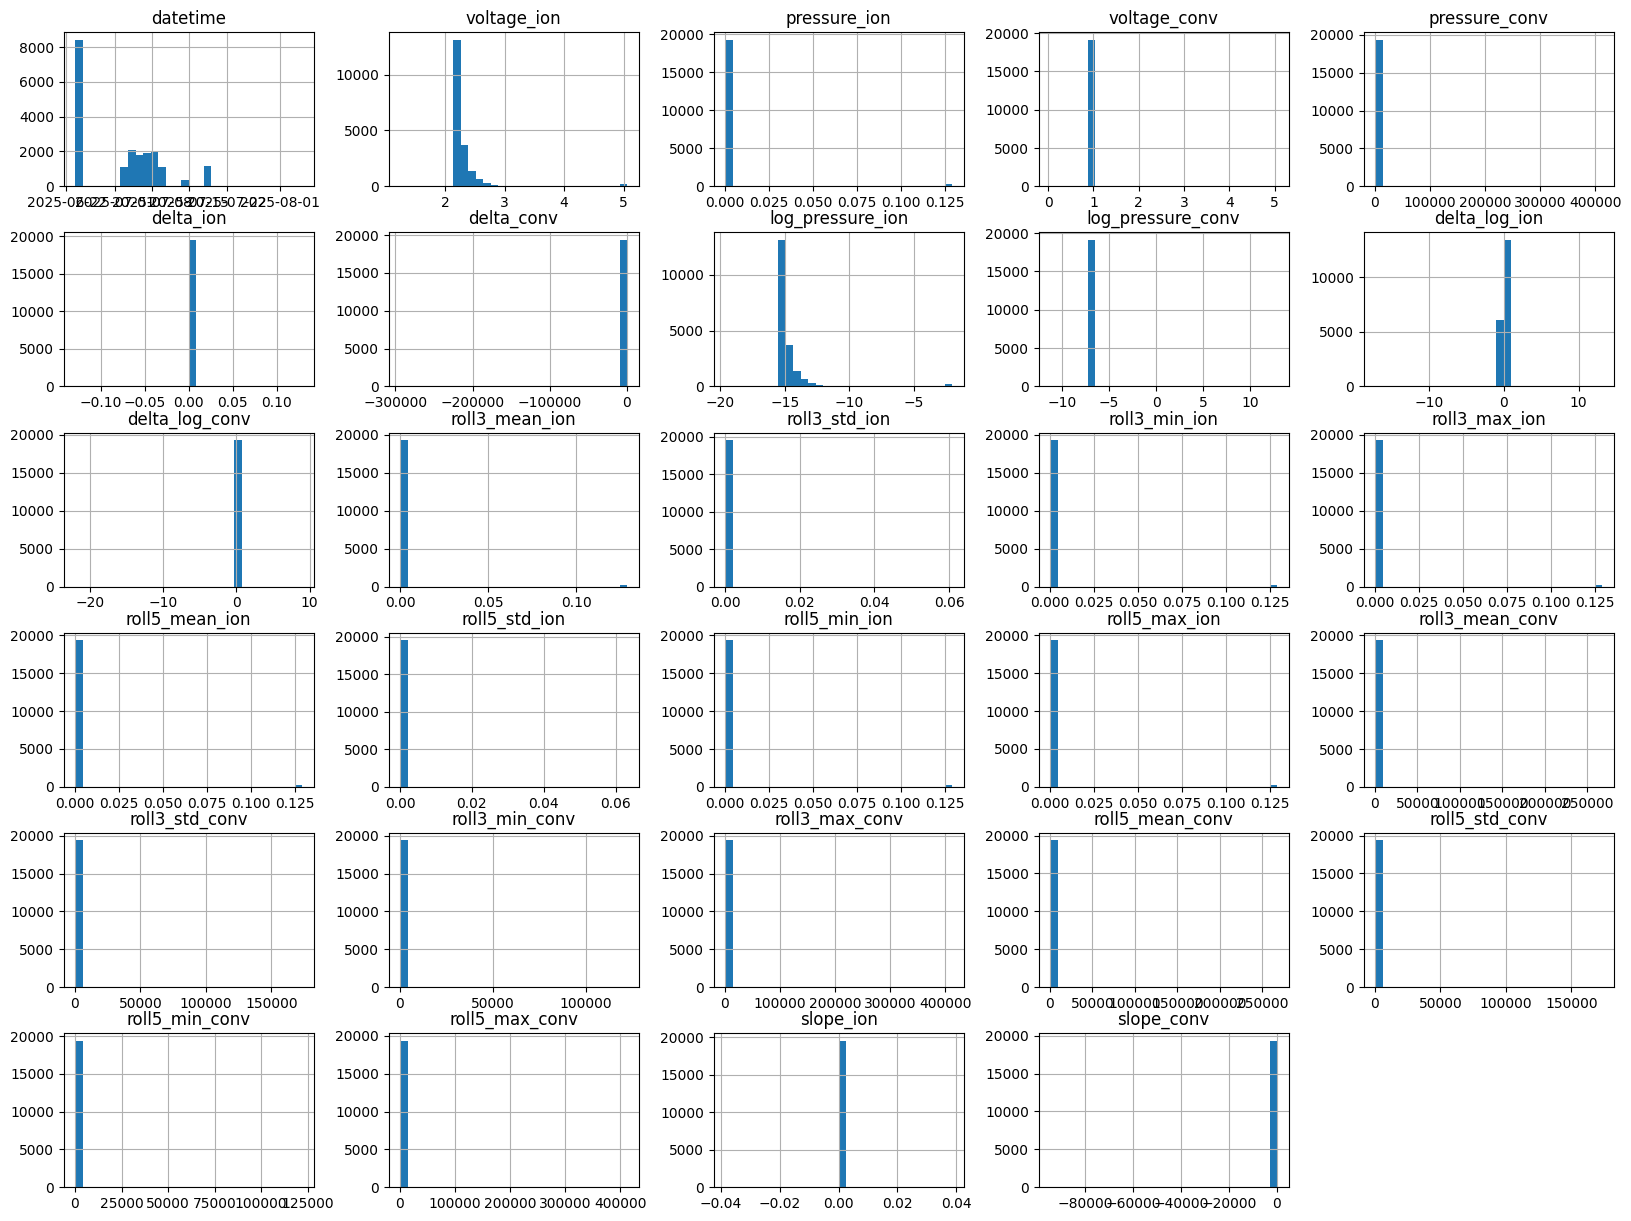

In [5]:
df_cleaned_engineered.hist(bins=30, figsize=(20,15))
plt.show()

<Axes: >

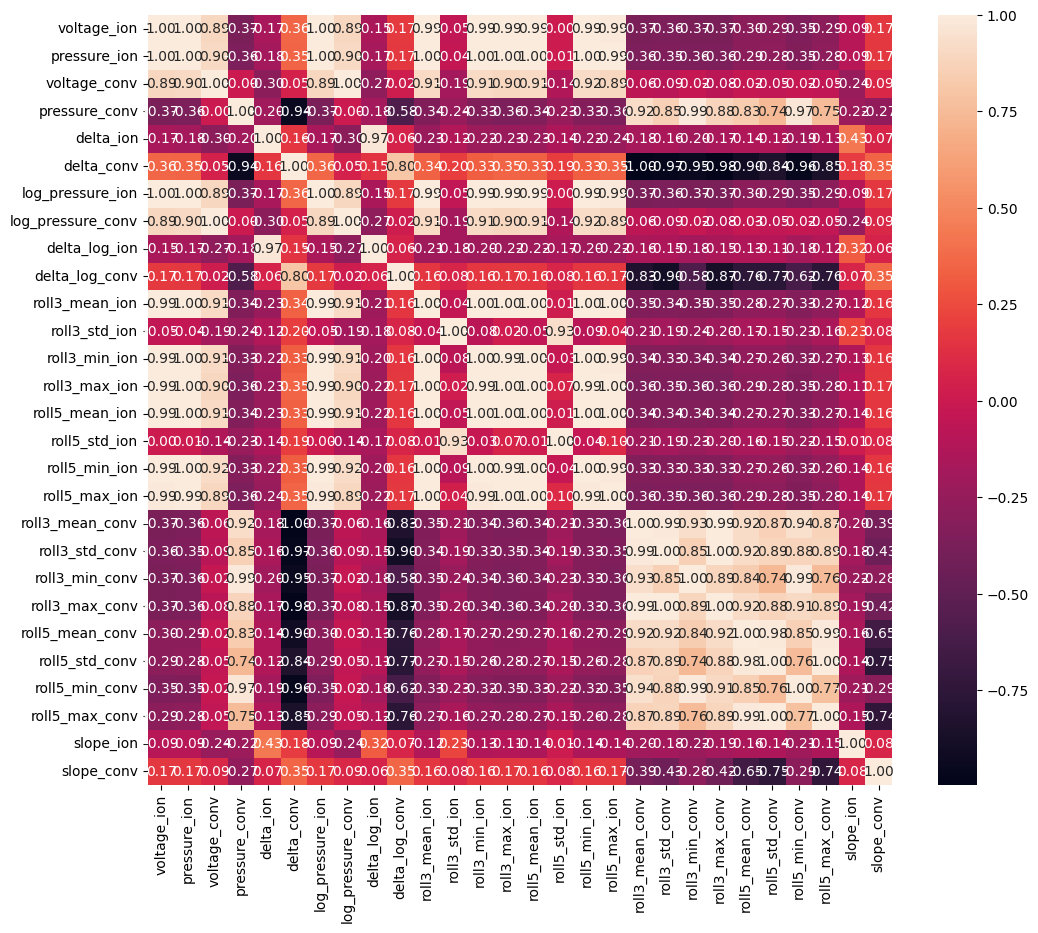

In [6]:
import seaborn as sns
df_heatmap = df_cleaned_engineered.select_dtypes(include='number').corr()
plt.figure(figsize=(12, 10))
sns.heatmap(df_heatmap.corr(), annot=True, fmt=".2f")

# Tags analysis

Create binary columns for key tag types

In [7]:
# Parse tags into list
#  Add binary columns for using MultiLabelBinarizer from sklearn
# Derive IG_state & CG_state

df_tags = tag_events(df_cleaned_engineered)

# Summary tag frequencies

In [8]:
# Tag frequencies
print("Tag Frequencies:\n", tag_frequencies(df_tags))

Tag Frequencies:
                   Tag  Count
0               CG on  19374
1               IG on  19276
2              IG off    719
3              CG off    658
4             venting    136
5               RP on    120
6   gate manipulation     64
7          IG turn on     27
8          IG slow on     18
9          CG turn on     12
10       chamber open     11
11        IG turn off     10
12        CG turn off      5
13            IG fail      5


# Detect anomalies

In [25]:
pd.set_option("display.max_columns", None)
df_altered = detect_anomalies(df_tags)
df_anomalies_ion = df_altered[df_altered["anomaly_if_ion"] == -1]
df_anomalies_conv = df_altered[df_altered["anomaly_if_conv"] == -1]
num_anomalies_ion = df_anomalies_ion.shape[0]
num_anomalies_conv = df_anomalies_conv.shape[0]
print(f"Number of Ion anomalies detected: {num_anomalies_ion}")
print(f"Number of Convectron anomalies detected: {num_anomalies_conv}")
num_anomalies = (df_altered["anomaly_if"] == -1).sum()
print(f"Number of anomalies detected: {num_anomalies}")

Number of Ion anomalies detected: 13
Number of Convectron anomalies detected: 201
Number of anomalies detected: 214


In [10]:
df_altered[df_altered['anomaly_if'] == -1].describe()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll3_mean_ion,roll3_std_ion,roll3_min_ion,roll3_max_ion,roll5_mean_ion,roll5_std_ion,roll5_min_ion,roll5_max_ion,roll3_mean_conv,roll3_std_conv,roll3_min_conv,roll3_max_conv,roll5_mean_conv,roll5_std_conv,roll5_min_conv,roll5_max_conv,slope_ion,slope_conv,tag_IG_on,tag_IG_off,tag_IG_fail,tag_IG_turn_on,tag_IG_turn_off,tag_IG_slow_on,tag_CG_on,tag_CG_off,tag_CG_turn_off,tag_CG_turn_on,tag_gate_manipulation,tag_RP_on,tag_chamber_open,tag_venting,anomaly_if_ion,score_if_raw_ion,score_if_ion,anomaly_if_conv,score_if_raw_conv,score_if_conv,anomaly_if,score_if_raw,score_if
count,214,208.000000,2.080000e+02,212.000000,212.000000,2.080000e+02,210.000000,208.000000,212.000000,208.000000,210.000000,2.100000e+02,210.000000,2.100000e+02,2.100000e+02,2.110000e+02,211.000000,2.110000e+02,2.110000e+02,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,208.000000,192.000000,214.000000,214.000000,214.0,214.000000,214.000000,214.0,214.000000,214.000000,214.000000,214.000000,214.0,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.0,214.000000,214.000000
mean,2025-06-29 18:20:14.738317824,4.381635,9.799107e-02,2.785134,3861.395121,1.997625e-08,-7614.285623,-5.165058,1.957157,-0.015780,-0.533997,9.644353e-02,0.002027,9.460071e-02,9.890065e-02,9.525280e-02,0.002555,9.292963e-02,9.904327e-02,9871.257385,7465.102447,2697.452025,18785.069019,13169.076667,13609.057761,2130.994026,33740.676411,0.000744,-2167.708302,0.219626,0.757009,0.0,0.014019,0.023364,0.0,0.948598,0.004673,0.009346,0.037383,0.0,0.163551,0.051402,0.579439,0.878505,0.083621,-0.083621,-0.878505,-0.084366,0.084366,-1.0,-0.100473,0.100473
min,2025-06-23 14:29:52,1.300000,4.060000e-09,0.039500,0.000012,-1.290000e-01,-294000.000000,-19.322083,-11.322305,-17.274140,-22.103024,1.820000e-07,0.000000,4.060000e-09,1.820000e-07,1.820000e-07,0.000000,4.060000e-09,1.820000e-07,0.000668,0.000000,0.000012,0.001010,0.000805,0.000000,0.000012,0.001010,-0.025799,-94799.999680,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.000000,-0.051391,-0.427456,-1.000000,-0.176042,-0.351000,-1.0,-0.176042,0.001122
25%,2025-06-23 15:49:15.500000,5.060000,1.290000e-01,1.265000,0.004510,0.000000e+00,-20.000000,-2.047943,-5.402756,0.000000,-0.023896,4.300894e-02,0.000000,8.577500e-06,1.290000e-01,2.580282e-02,0.000000,2.380000e-06,1.290000e-01,0.009567,0.001225,0.001110,0.009798,4.270614,0.224978,0.001065,9.882500,0.000000,-0.001315,0.000000,1.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,-0.132565,0.055040,-1.0,-0.132565,0.055040
50%,2025-06-23 16:25:12.500000,5.060000,1.290000e-01,3.685000,551.000000,0.000000e+00,0.000000,-2.047943,6.311456,0.000000,0.000000,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,833.666667,10.370899,489.000000,847.000000,843.400000,11.267653,439.000000,921.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,-0.000000,-1.000000,-0.128063,0.128063,-1.0,-0.128063,0.128063
75%,2025-06-23 17:50:42,5.060000,1.290000e-01,3.800000,955.000000,0.000000e+00,13.750000,-2.047943,6.861711,0.000000,0.023872,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,962.666667,10.842304,955.000000,978.000000,968.800000,56.055569,955.000000,978.000000,0.000000,0.000519,0.000000,1.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,-0.000000,-1.000000,-0.055040,0.132565,-1.0,-0.055040,0.132565
max,2025-08-02 23:09:01,5.060000,1.290000e-01,4.800000,122000.000000,1.289998e-0

## stats

In [11]:

print(df_altered[["pressure_ion","pressure_conv"]].describe())
print(df_altered["IG_state"].value_counts())

       pressure_ion  pressure_conv
count  1.957000e+04   19387.000000
mean   1.608804e-03     112.427689
std    1.431444e-02    5622.526377
min    3.020000e-09       0.000012
25%    2.280000e-07       0.001010
50%    2.440000e-07       0.001010
75%    3.760000e-07       0.001030
max    1.290000e-01  413000.000000
IG_state
IG on          19276
IG off           719
IG turn on        27
IG slow on        17
IG turn off        6
IG fail            2
Name: count, dtype: int64


# Plots

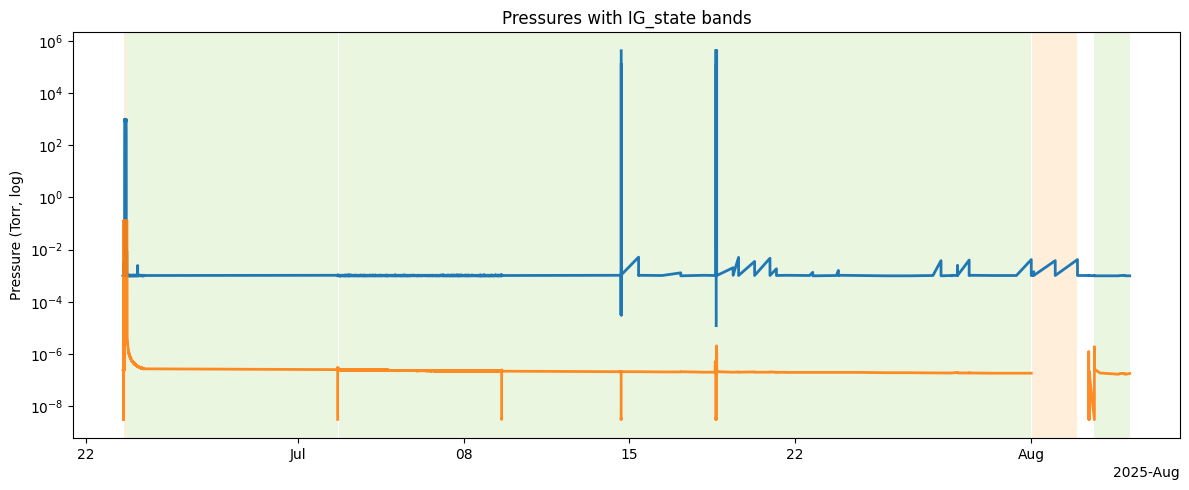

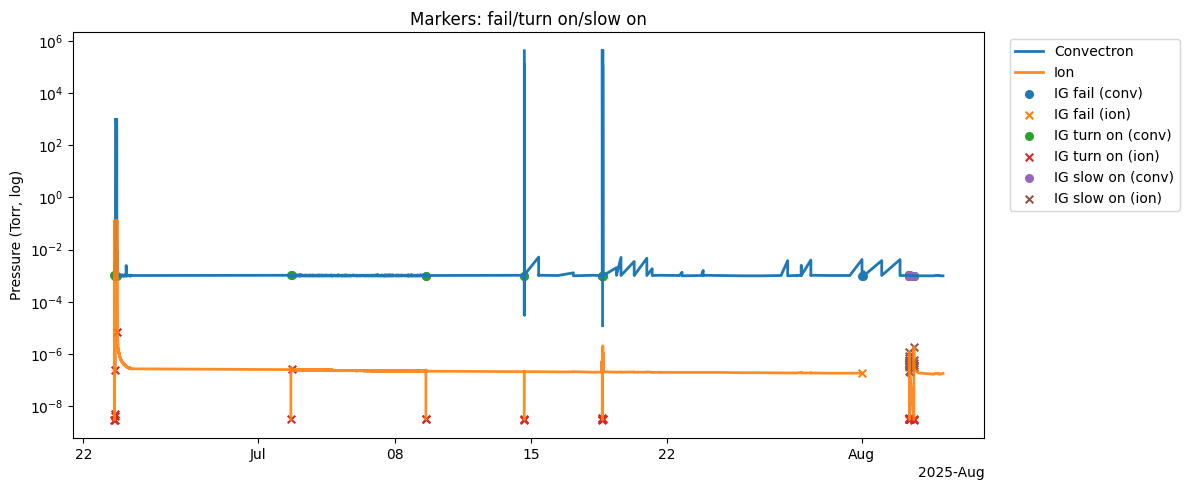

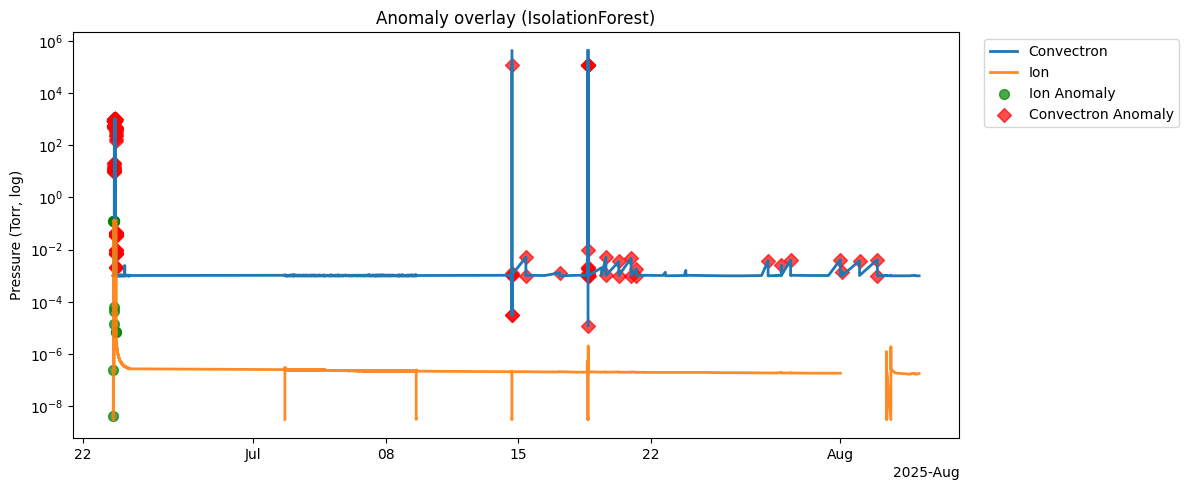

In [12]:

plot_time_with_state_bands(df_altered.reset_index(), title="Pressures with IG_state bands")
df_plot = df_altered.reset_index()
df_plot = df_plot[df_plot["datetime"] <= "2025-06-23 20:00:00"]
plot_time_with_tag_markers(
    df_altered,
    tags_to_mark=("IG fail", "IG turn on", "IG slow on"),
    title="Markers: fail/turn on/slow on",
    savepath=OUTPUT_PLOTS / "markers_fail_turnon_slowon_eng.png"
)

plot_anomalies(df_altered, title="Anomaly overlay (IsolationForest)", savepath=OUTPUT_PLOTS / "anomalies_overlay_eng.png")


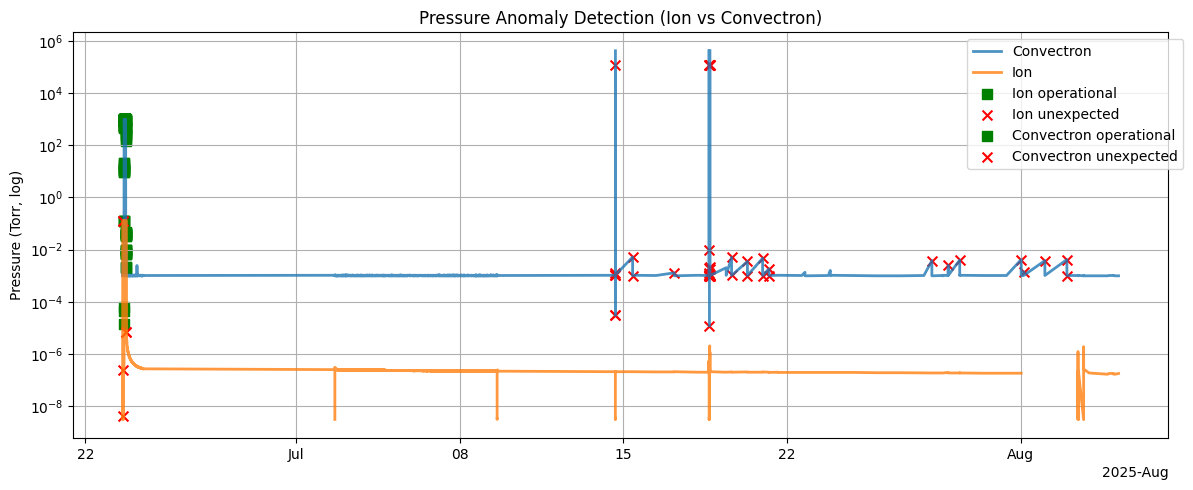

In [26]:
df_feat = tag_anomalies(df_altered)
plot_tag_anomalies(df_feat, title="Pressure Anomaly Detection (Ion vs Convectron)", savepath=OUTPUT_PLOTS / "pressure_anomaly_detection_eng.png")


In [14]:
out = DATA_PROCESSED / "processed_eng.csv"
df_altered.to_csv(out, index=False)
print(f"Saved combined data to {out}")

Saved combined data to ..\data\processed\processed_eng.csv
